In [1]:
%matplotlib widget
from bmcs_shear.shear_crack.crack_tip_orientation import SZCrackTipOrientation
from bmcs_utils.api import InteractiveWindow

In [5]:
sz_cto = SZCrackTipOrientation()

In [17]:
sz_cto.sz_bd.cross_section_layout.reinforcement.z_j[0] = 25
sz_cto.sz_bd.cross_section_layout.reinforcement.A_j[0] = 100
sz_cto.sz_bd.cross_section_layout.reinforcement.E_j[0] = 210000 / 100

In [18]:
sz_cto.sz_stress_profile.ds.sz_ctr.x_rot_1k = 59.303

In [19]:
InteractiveWindow([sz_cto, sz_cto.crack_tip_shear_stress, sz_cto.sz_stress_profile]).interact()

In [1]:
import sympy as sp
import numpy as np
import matplotlib.pylab as plt
sp.init_printing()

# Principal stress directions in FPS

The corresponding tensile stress at this position which must be perpendicular to the crack propagation
\begin{align}
\sigma^{\mathrm{tip},\psi}_1 = f_{\mathrm{t}}
\end{align}

\begin{align}
\sigma_{ij} =
\left[
\begin{array}{cc}
\sigma_{x} & \tau^\mathrm{tip} \\
\tau^\mathrm{tip} & \sigma_{z}
\end{array}
\right]
\end{align}

In [2]:
tau_tip, sigma_x, sigma_z = sp.symbols(r'\tau^\mathrm{tip}, sigma_x, sigma_z')

In [3]:
f_ct = sp.Symbol('f_{\mathrm{ct}}', nonnegative=True)

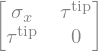

In [4]:
sigma_xz = sp.Matrix([[sigma_x, tau_tip],
                     [tau_tip, sigma_z]])
sigma_x0 = sigma_xz.subs(sigma_z,0)
sigma_x0

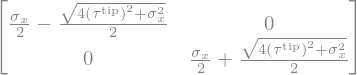

In [5]:
P_xz, D_xz = sigma_xz.diagonalize()
P_x0, D_x0 = P_xz.subs(sigma_z,0), D_xz.subs(sigma_z,0)
D_x0

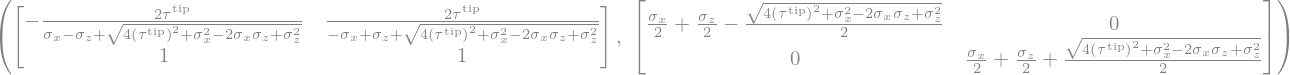

In [6]:
P_xz, D_xz

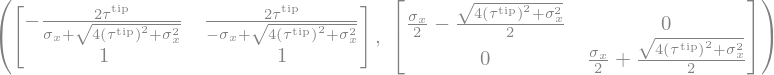

In [7]:
P_x0, D_x0

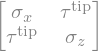

In [8]:
sp.simplify(P_xz* D_xz * P_xz**(-1))

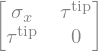

In [9]:
sp.simplify(P_x0* D_x0 * P_x0**(-1))

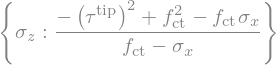

In [10]:
subs_sigma_z = sp.solve({D_xz[1,1] - f_ct}, {sigma_z})[0]
subs_sigma_z

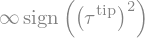

In [11]:
sp.limit( sigma_z.subs(subs_sigma_z), sigma_x, f_ct)

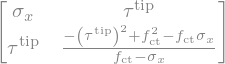

In [12]:
sigma_xf = sigma_xz.subs(subs_sigma_z)
sigma_xf

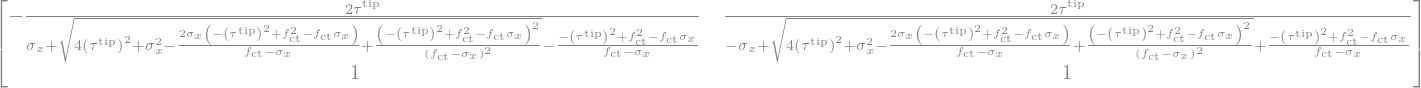

In [13]:
P_xf = P_xz.subs(subs_sigma_z)
D_xf = D_xz.subs(subs_sigma_z)
P_xf

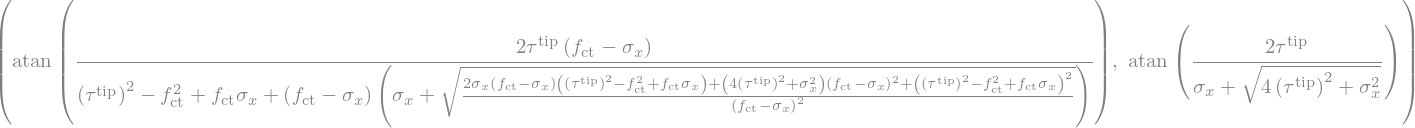

In [14]:
theta_f = sp.atan( sp.simplify(-P_xf[0,0] / P_xf[1,0]))
theta_0 = sp.atan( sp.simplify(-P_x0[0,0] / P_x0[1,0]))
theta_f, theta_0

In [15]:
get_theta_f = sp.lambdify((tau_tip, sigma_x, f_ct), theta_f)
get_theta_0 = sp.lambdify((tau_tip, sigma_x, f_ct), theta_0)

In [16]:
get_sigma_z = sp.lambdify((tau_tip, sigma_x, f_ct),sigma_z.subs(subs_sigma_z))

In [17]:
f_ct_val = 3

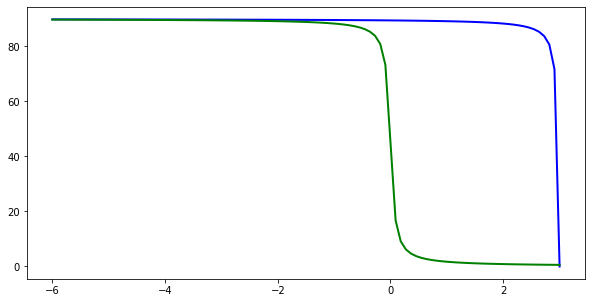

In [18]:
_, (ax1) = plt.subplots(1, 1, figsize=(10,5))
sig_x = np.linspace(f_ct_val - 0.000001,-2*f_ct_val,100)
eta = 0.01
tau_xx = eta * f_ct_val
th_f = get_theta_f(
    tau_xx,sig_x[:, np.newaxis], f_ct_val)
th_0 = get_theta_0(
    tau_xx,sig_x[:, np.newaxis], f_ct_val)
ax1.plot(sig_x, th_f/np.pi * 180, color='blue', lw=2);
ax1.plot(sig_x, th_0/np.pi * 180, color='green', lw=2);

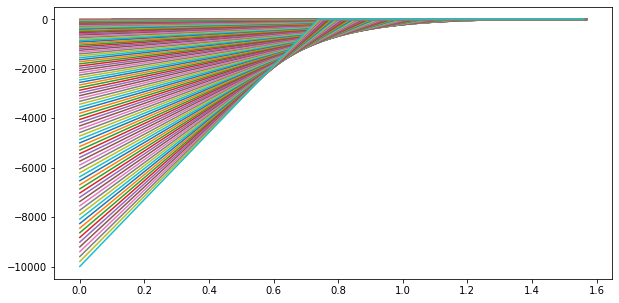

In [19]:
_, (ax1) = plt.subplots(1, 1, figsize=(10,5))
tau_val = np.linspace(0.00001, 0.1, 100)
th_f = get_theta_f(
    tau_val[np.newaxis, :],
    sig_x[:, np.newaxis], f_ct_val)
sig_z = get_sigma_z(
    tau_val[np.newaxis, :],
    sig_x[:, np.newaxis], f_ct_val)
ax1.plot(th_f, sig_z);

In [20]:
DELTA = np.ones(2)
P_x0_norm = P_x0.norm()
get_P_x0 = sp.lambdify((tau_tip, sigma_x, f_ct), P_x0, 'numpy')
get_P_xf = sp.lambdify((tau_tip, sigma_x, f_ct), P_xf, 'numpy')
get_D_x0 = sp.lambdify((tau_tip, sigma_x, f_ct), D_x0, 'numpy')
get_D_xf = sp.lambdify((tau_tip, sigma_x, f_ct), D_xf, 'numpy')

In [21]:
def get_D_x0_vals(tau_val = 1, sig_val = 2.8, f_ct = 3.0):
    D_x0_vals = get_D_x0(tau_val,sig_val, f_ct)
    D_x0_vct = np.einsum('...i,...ij->...j', DELTA, D_x0_vals)
    return D_x0_vct[np.newaxis,:]

In [22]:
def get_D_xf_vals(tau_val = 1, sig_val = 2.8, f_ct = 3):
    D_xf_vals = get_D_xf(tau_val,sig_val,f_ct)
    D_xf_vct = np.einsum('i,ij->j', DELTA, D_xf_vals)
    return D_xf_vct[np.newaxis,:]

In [23]:
def get_T_x0_args(tau_val, sig_val, f_ct):
    P_x0_vals = get_P_x0(tau_val,sig_val,f_ct)
    print(P_x0_vals)
    norm_P_x0_vals2 = np.sqrt(np.einsum('ij,ij->j', P_x0_vals, P_x0_vals))
    T_x0 = P_x0_vals / norm_P_x0_vals2
    T_x0_scaled = T_x0 * get_D_x0_vals(tau_val, sig_val, f_ct)
    T_x0_0 = np.zeros_like(T_x0)
    T_x0_args = np.einsum('ijk->jik', np.array([T_x0_0, T_x0_scaled]))
    return T_x0_args

In [24]:
def get_T_xf_args(tau_val, sig_val, f_ct, pos = np.array([[0,0]])):
    P_xf_vals = get_P_xf(tau_val,sig_val,f_ct)
    norm_P_xf_vals2 = np.sqrt(np.einsum('ij,ij->j', P_xf_vals, P_xf_vals))
    T_xf = P_xf_vals / norm_P_xf_vals2
    T_xf_scaled = T_xf * get_D_xf_vals(tau_val, sig_val, f_ct)
    T_xf_0 = np.zeros_like(T_xf)
    T_vxt = np.array([T_xf_0, T_xf_scaled])
    pos_lk = pos
    T_xf_args = pos_lk[:,None,:, None] + T_vxt[None,:,:,:]
    return np.einsum('lijk->jlik', T_xf_args)

In [25]:
tau_, sig_x_ = 1, 0.1
T_xf_args = get_T_xf_args(2,sig_x_,3, np.array([[1,0]]))
T_xf_args

array([[[[ 1.        ,  1.        ],
         [ 2.05314463,  2.70319887]]],


       [[[ 0.        ,  0.        ],
         [-0.72630664,  2.46963836]]]])

In [26]:
sig_x_ = np.linspace(2.5, -2.5, 4)
sig_z_ = get_sigma_z(tau_,sig_x_, f_ct_val)
pos_lk = np.c_[sig_x_, sig_z_]
pos_lk

array([[ 2.5       ,  1.        ],
       [ 0.83333333,  2.53846154],
       [-0.83333333,  2.73913043],
       [-2.5       ,  2.81818182]])

[[-0.95124922  1.05124922]
 [ 1.          1.        ]]


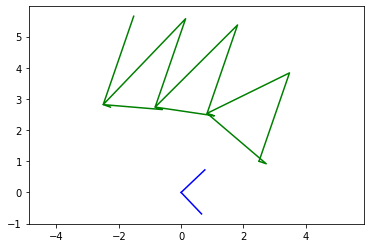

In [29]:
tau_, sig_x_ = 1, 0.1
T_x0_args = get_T_x0_args(tau_,sig_x_,3)
T_xf_args = get_T_xf_args(tau_,sig_x_,3, pos_lk)
fix, ax = plt.subplots(1,1)
ax.axis('equal');
ax.plot(*T_x0_args, color='blue');
ax.plot(*T_xf_args.reshape(2,-1,2), color='green');